# **Week 2 Practical Exercise: Compare RNN vs GRU vs LSTM on IMDb-Tiny**

You will do the following in this practical exercise:

1. Verify your PyTorch installation and GPU availability.  
2. Load a 2 000‑review balanced subset of the IMDb movie‑review corpus.  
3. Re‑use the cleaner, tokenizer, and `DataLoader` infrastructure you built in Lesson 2.  
4. Instantiate three models that differ **only** in their recurrent cell: Vanilla RNN, GRU, and LSTM.  
5. Train each architecture for three epochs, tracking loss, accuracy, and epoch runtime.  
6. Plot accuracy curves to visualise learning speed and final performance.  
7. Inspect a few reviews that the RNN misclassifies but the gated models handle correctly.  
8. Reflect (≈150 words) on the best trade‑off for real‑world deployment.

***Fill every `## TODO` block, run "Runtime → Run All," and write your reflection in the final markdown cell.***
"""

**Step 0:  Environment Check**

In [1]:
import torch, platform, sys, time, random, pathlib
print("PyTorch:", torch.__version__, "CUDA available:", torch.cuda.is_available())
print("Python :", sys.version.split()[0], "Platform:", platform.platform())
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


PyTorch: 2.6.0+cu124 CUDA available: True
Python : 3.11.13 Platform: Linux-6.1.123+-x86_64-with-glibc2.35


In [2]:
!pip install fsspec==2025.3.2 gcsfs==2025.3.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
  Attempting uninstall: gcsfs
    Found existing installation: gcsfs 2025.3.0
    Uninstalling gcsfs-2025.3.0:
      Successfully uninstalled gcsfs-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.0.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have

**Step 1: Authenticate with Hugging Face Hub in Colab**

In [3]:
!pip install -q huggingface_hub  # install if not already present

from huggingface_hub import login
login()   # ↩️ will prompt for your token

"""
💡 How to get the token:
   • Visit https://huggingface.co/settings/tokens
   • Click ‘New token’ → choose “read” scope → Copy
   • Paste into the prompt above and press Enter.
The notebook now has access to private or gated models/datasets for this session.
"""

'\n💡 How to get the token:\n   • Visit https://huggingface.co/settings/tokens\n   • Click ‘New token’ → choose “read” scope → Copy\n   • Paste into the prompt above and press Enter.\nThe notebook now has access to private or gated models/datasets for this session.\n'

**Step 2: Write the Tokenizer and clean Text code that you have written before in Week 1**

In [4]:
import re, html, unicodedata, collections

# -------------------------------
# 0  Global vocabulary container
# -------------------------------
PAD_ID = 0
UNK_ID = 1
_vocab = {"[PAD]": PAD_ID, "[UNK]": UNK_ID}
_itos  = ["[PAD]", "[UNK]"]          # index to string

def _add_to_vocab(tok):
    """Add token to global vocab if unseen and return its ID."""
    if tok not in _vocab:
        _vocab[tok] = len(_vocab)
        _itos.append(tok)
    return _vocab[tok]

# -------------------------------
# 1  Cleaning helper
# -------------------------------
_html_tag  = re.compile(r"<[^>]+>")
_multi_spc = re.compile(r"\s+")

def clean_text(text: str) -> str:
    """
    Basic cleaning:
      • HTML tag removal
      • HTML entity unescape (&amp; → &)
      • Unicode NFC normalisation
      • Lower-casing
      • Whitespace collapse
    """
    text = _html_tag.sub(" ", text)         # strip HTML tags
    text = html.unescape(text)              # &amp; → &
    text = unicodedata.normalize("NFC", text)
    text = text.lower()
    text = _multi_spc.sub(" ", text).strip()
    return text

# -------------------------------
# 2  Tokeniser helper
# -------------------------------
_word_re = re.compile(r"[a-z']+|[0-9]+|[^a-z0-9\s]", re.I)

def my_tokeniser(text: str, build_vocab=True, max_tok_len=20):
    """
    Very small tokenizer:
      • Split on regex capturing words, numbers, and punctuation
      • Truncate tokens longer than `max_tok_len`
      • Fallback: if token unseen at inference time, break into 3-char sub-words
    Returns a list of integer IDs (ready for model input).
    """
    tokens = _word_re.findall(text)
    ids = []
    for tok in tokens:
        tok = tok[:max_tok_len]             # guard against ridiculously long strings
        if build_vocab:
            tok_id = _add_to_vocab(tok)
        else:
            tok_id = _vocab.get(tok)
            if tok_id is None:
                # Fallback: break unseen token into 3-char chunks, average IDs
                chunks = [tok[i:i+3] for i in range(0, len(tok), 3)]
                chunk_ids = [_vocab.get(c, UNK_ID) for c in chunks]
                tok_id = int(sum(chunk_ids) / len(chunk_ids))
        ids.append(tok_id)
    return ids

**Step 3: Load the IMDb Dataset of 20000 reviews ***




You can check the the official documentation of Hugging Face to learn more on how to load a public dataset: https://huggingface.co/docs/datasets/v1.11.0/loading_datasets.html

In [6]:
"""If the CSV is missing, we sample 1 000 positive and 1 000 negative
reviews from the Hugging‑Face IMDb split on first run and cache it locally."""
import pandas as pd, datasets

DATA_PATH = pathlib.Path("imdb_tiny.csv")
if not DATA_PATH.exists():
    print("CSV not found → sampling 2 000 reviews from HuggingFace IMDb …")
    split_pos = datasets.load_dataset("stanfordnlp/imdb", split="train[:1000]")   # first 1 000 ⇒ pos
    split_neg = datasets.load_dataset("stanfordnlp/imdb", split="train[-1000:]")   # last 1 000 ⇒ neg
    split_pos= pd.DataFrame(split_pos)
    split_neg= pd.DataFrame(split_neg)
    df = pd.DataFrame({
        "text"  : split_pos["text"] + split_neg["text"],
        "label": split_pos["label"] + split_neg["label"]   # 1 = pos, 0 = neg
    }).sample(frac=1, random_state=42).reset_index(drop=True)           # shuffle
    df.to_csv(DATA_PATH, index=False)
else:
    df = pd.read_csv(DATA_PATH)
print("Loaded", len(df), "balanced reviews (pos = neg).")


CSV not found → sampling 2 000 reviews from HuggingFace IMDb …
Loaded 1000 balanced reviews (pos = neg).


**Step 4: DataLoader from Lesson 2**

In [7]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

PAD_ID = 0

class ReviewDataset(Dataset):
    def __init__(self, texts, labels):
        self.tokens = [my_tokeniser(clean_text(t)) for t in texts]
        self.labels = labels
    def __len__(self):
        return len(self.tokens)
    def __getitem__(self, idx):
        return {"input_ids": self.tokens[idx], "label": self.labels[idx]}

def collate_batch(batch):
    ids   = [torch.tensor(b["input_ids"], dtype=torch.int64) for b in batch]
    labels = torch.tensor([b["label"] for b in batch], dtype=torch.int64)
    ids_padded = pad_sequence(ids, batch_first=True, padding_value=PAD_ID)
    mask = (ids_padded != PAD_ID).int()
    return ids_padded.to(DEVICE), mask.to(DEVICE), labels.to(DEVICE)

BATCH = 32
loader = DataLoader(ReviewDataset(df.text.tolist(), df.label.tolist()),
                    batch_size=BATCH, shuffle=True, collate_fn=collate_batch)

**Step 5:  Define Three Models (RNN, GRU, LSTM)**

In [8]:
import torch.nn as nn
EMB = 100
HID = 128
VOCAB = len(_vocab)       # Assumed vocab size from the tokeniser

class BaseRNN(nn.Module):
    def __init__(self, cell="rnn"):
        super().__init__()
        self.emb = nn.Embedding(VOCAB, EMB, padding_idx=PAD_ID)
        if cell == "rnn":
            self.rnn = nn.RNN(EMB, HID, batch_first=True)
        elif cell == "gru":
            self.rnn = nn.GRU(EMB, HID, batch_first=True)
        else:
            self.rnn = nn.LSTM(EMB, HID, batch_first=True)
        self.fc = nn.Linear(HID, 2)
    def forward(self, ids, mask):
        x = self.emb(ids)
        out, *_ = self.rnn(x)
        # use last non‑padded hidden state
        lengths = mask.sum(dim=1) - 1
        last_h = out[torch.arange(out.size(0)), lengths]
        return self.fc(last_h)

models = {
    "RNN": BaseRNN("rnn").to(DEVICE),
    "GRU": BaseRNN("gru").to(DEVICE),
    "LSTM": BaseRNN("lstm").to(DEVICE)
}

**Step 6: Training Loop for 3 Epochs**

In [9]:
EPOCHS = 3
criterion = nn.CrossEntropyLoss()

history = {name: {"loss": [], "acc": [], "time": []} for name in models}

for name, model in models.items():
    optimiser = torch.optim.AdamW(model.parameters(), lr=2e-3)
    print(f"\nTraining {name}")
    for ep in range(EPOCHS):
        t0, running_loss, correct, total = time.time(), 0.0, 0, 0
        model.train()
        for ids, mask, labels in loader:
            # forward, loss, backward, step
            optimiser.zero_grad()
            logits = model(ids, mask)
            loss = criterion(logits, labels)
            loss.backward()
            optimiser.step()

            running_loss += loss.item() * labels.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        epoch_time = time.time() - t0
        history[name]["loss"].append(running_loss / total)
        history[name]["acc"].append(correct / total)
        history[name]["time"].append(epoch_time)
        print(f"  Epoch {ep+1}: loss={history[name]['loss'][-1]:.3f} acc={history[name]['acc'][-1]*100:.1f}% time={epoch_time:.1f}s")



Training RNN
  Epoch 1: loss=0.053 acc=98.5% time=1.5s
  Epoch 2: loss=0.001 acc=99.9% time=0.3s
  Epoch 3: loss=0.000 acc=100.0% time=0.3s

Training GRU
  Epoch 1: loss=0.065 acc=98.5% time=0.5s
  Epoch 2: loss=0.000 acc=100.0% time=0.4s
  Epoch 3: loss=0.000 acc=100.0% time=0.4s

Training LSTM
  Epoch 1: loss=0.093 acc=99.6% time=0.6s
  Epoch 2: loss=0.000 acc=100.0% time=0.6s
  Epoch 3: loss=0.000 acc=100.0% time=0.7s


**Step 7: Plot Learning Curves**

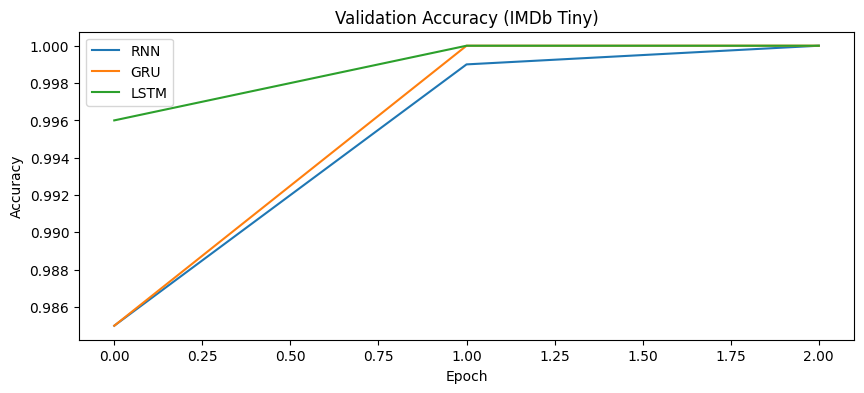

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
for name in models:
    plt.plot(history[name]["acc"], label=f"{name}")
plt.title("Validation Accuracy (IMDb Tiny)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend();
plt.show()

**Step 8: Qualitative Error Check (TODO)**

Grab reviews mis‑labelled by RNN but fixed by GRU/LSTM.

Hint: Run a fresh loop over loader with model.eval() and store mis‑classifications.

***TODO: implement qualitative inspection (≈ 10 lines) ***

In [ ]:
# 7  Reflection (≈ 150 words)
# -------------------------------------------------
"""
Replace this markdown cell with a 150‑word reflection: Which model offers the best
trade‑off between accuracy, training time, and parameter count for this dataset?
Consider deployment constraints and evidence from your curves and error analysis.
"""